In [1]:
%matplotlib inline

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import strid
import scipy.signal
import scipy.integrate

First we create a measured signal, we use a shear frame and apply a initial displacement d0 and perform FDD on the free vibration acceleration signal.

In [54]:
sf = strid.utils.ShearFrame(20, 1e3, 1e6)

# damping
freqs, damp = [5, sf.find_natural_frequency(25)], [.05]*2
#sf.set_rayleigh_damping_matrix(freqs, damp)
a, b = strid.utils.find_rayleigh_damping_coeffs(freqs, damp)
xi_true = lambda w: .5*(a/w+b*w)
M, C, K = sf.M, sf.C, sf.K
fs = 500
dt = 1/fs
T = 100 #s

n = sf.n
F = np.zeros((n, int(T*fs)))
v0 = np.zeros(n)
d0 = np.random.normal(size=n) * 10 + 100

A, V, D = strid.generalized_alpha_method(M, C, K, F, dt, d0, v0, rho=.5)
Y = A.copy()

In [55]:
As, Bs = sf.find_state_matrix()
Bs = np.zeros((As.shape[0], 1))
#Bs[0, 0] = 1
Cs = np.eye(As.shape[0])
Ds = Bs.copy()

def solve(x, t):
    dxdt = As.dot(x) #+ Bs.dot(u)
    return dxdt



sys = scipy.signal.StateSpace(*(As, Bs, Cs, Ds), dt=1/5000)

(50000, 40)
-60.39621390588428 84.51581488721006


(0, 15)

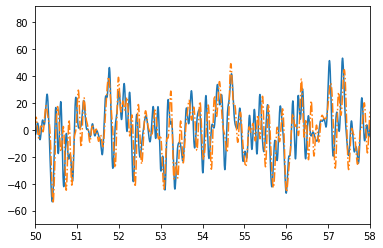

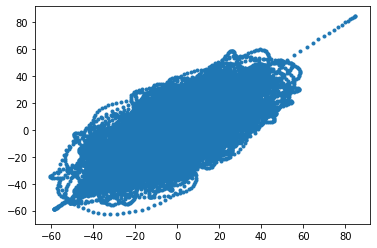

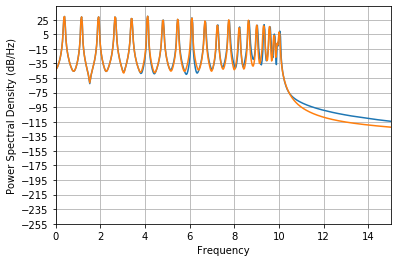

In [56]:
x0 = np.r_[v0, d0]
u = np.zeros(F.shape[1])

tout = np.arange(int(T*fs))/fs #out, yout, xout = scipy.signal.dlsim(sys, u, x0=x0)
xout = scipy.integrate.odeint(solve, x0 ,tout)

print(xout.shape)
Dsys = xout[:, n:].T
plt.plot(tout, Dsys[0])
plt.plot(tout, D[0], "-.")
print(Dsys[0].min(), Dsys[0].max())
#plt.xlim(0, 0.1)
plt.xlim(50, 58)
plt.figure()
plt.plot(Dsys[0], D[0], '.')
plt.figure()
for d in [Dsys[0], D[0]]:
    plt.psd(d, Fs=fs, NFFT=2**14)
    
plt.xlim(0, 15)
#plt.ylim(np.abs(D[0, :1000]).min(), np.abs(D[0, :1000]).max())

In [304]:
class CovSSI(object):
    def __init__(self, Y, fs):
        self.Y = Y
        self.fs = fs
        
    def R(self, i):
        l, N = self.Y.shape
        return self.Y[:, :N-i].dot(self.Y[:, i:].T) /(N-i)
    
    def get_block_toeplitz(self, block_rows, lag=0):
        l, N = self.Y.shape
        T = np.zeros((l*block_rows, l*block_rows))
        for r in range(block_rows):
            for c in range(block_rows):
                i = block_rows + r - c + lag
                T[r*l:(r+1)*l, c*l:(c+1)*l] = self.R(i)
        return T
        
    def compute_state_matrix_BR(self, block_rows, max_order):
        l, N = self.Y.shape
        T = self.get_block_toeplitz(block_rows)
        U, s, VT = np.linalg.svd(T)
        As = []
        for i in range(1, max_order+1, 5):
            Ui = U[:, :i]
            Si = np.diag(s[:i])
            Vi = VT[:i].T
            O = Ui.dot(np.sqrt(Si))
            Oup = O[:-l, :]
            Odwn = O[l:, :]
            A = np.linalg.lstsq(Oup, Odwn)[0]
            C = O[:l, :]
            As.append((i, A, C))
        return As
    
    def eigval_to_damping(self, eigval):
        u = self.fs * np.log(eigval)
        return -u.real / np.abs(u)
    
    def eigval_to_freq(self, eigval):
        u = self.fs * np.log(eigval)
        xi = self.eigval_to_damping(eigval)
        return u.imag / np.sqrt(1-xi**2)
    
    def find_modal_prop(self, block_rows):
        A = self.compute_state_matrix_BR(block_rows, None)
        l0, Q0 = np.linalg.eig(A)
        u = self.fs * np.log(l0)
        l = l0[u.imag >=0]
        Q = Q0[:, u.imag >=0]
        f = self.eigval_to_freq(l)
        n = np.argsort(f)
        
        return f[n], self.eigval_to_damping(l)[n], Q[:, n]

In [305]:
cs = CovSSI(Y, fs)

In [306]:
As = cs.compute_state_matrix_BR(10, 120)

/home/gunnstein/.local/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [307]:
Pyy = strid.utils.find_psd_matrix(Y, nperseg=2**14)

(20, 116) (116, 59)
(20, 59)


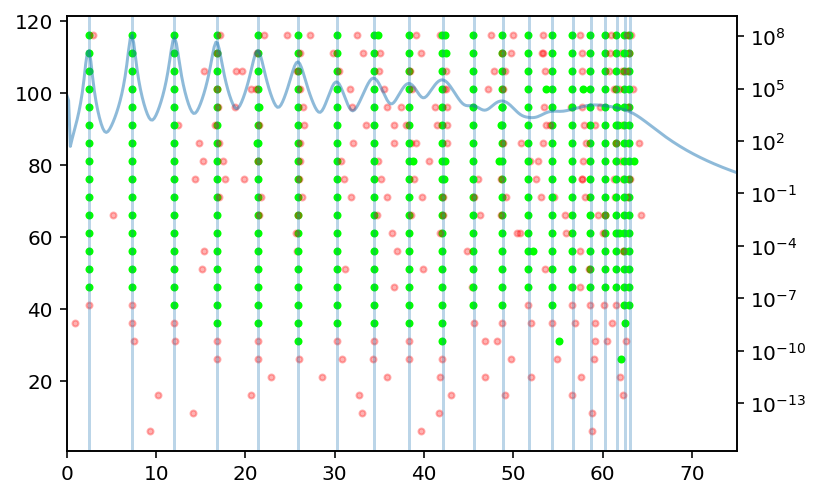

In [308]:
plt.figure(dpi=144)
w0 = None
xi0 = None
for i, A, C in As:
    lr, Q = np.linalg.eig(A)
    u = cs.fs*np.log(lr)
    mask = u.imag > 0
    u = u[mask]
    Q = Q[:, mask]
    xi = -u.real / np.abs(u)
    w = u.imag / np.sqrt(1-xi**2)
    Phi = C.dot(Q).real
    if w0 is None:
        w0 = w
        xi0 = xi
    for xii, wi in zip(xi, w):
        c = (1, 0, 0, .3)
        if np.any((np.abs(w0 - wi)/w0 < 0.01) & (np.abs(xi0-xii)/(xi0)<0.05)):
            c = (0, 1, 0, 1)
        plt.plot(wi, i, '.', color=c)
    plt.xlim(0, 75)
    w0 = w
    xi0 = xi
print(C.shape, Q.shape)
print(Phi.shape)
for r in range(1, cs.Y.shape[0]+1):
    plt.axvline(sf.find_natural_frequency(r), alpha=.3)
    
ax2 = plt.gca().twinx()
psd = np.trace(Pyy, axis1=1, axis2=2)
f = strid.utils.get_frequency_vector(fs, psd.size)
ax2.semilogy(f*2*np.pi, psd, alpha=.5)

In [309]:
print(Phi)

[[ 1.42498937e-05 -1.75959692e-05 -1.83646514e-05 ...  1.02331155e+00
   2.87793154e-01  1.38866431e+00]
 [-4.84142289e-06  7.52395724e-06 -8.18862314e-06 ... -2.44225556e-01
   1.14402695e+00  7.29362233e-01]
 [ 1.78549808e-06  1.47555776e-05 -3.15945557e-05 ... -6.80687173e-01
   9.39570921e-01  4.04083669e-01]
 ...
 [ 1.55499172e-06 -2.75975255e-06 -4.25766466e-07 ...  3.21319802e-01
  -1.56757558e-01 -8.97220483e-02]
 [-9.09646961e-07  9.68906397e-07  6.88567264e-08 ... -2.75538330e-02
  -5.02641636e-03 -1.84628759e-01]
 [-5.16248184e-06  3.31605149e-06 -3.51197778e-06 ... -5.70679149e-01
   2.52347243e-01 -4.73790188e-01]]


  45.5 |  42.1 |     8.2% | 80.0% | 9
  42.1 |  42.1 |    -0.1% | 90.4% | 9
  42.4 |  42.1 |     0.7% | 92.6% | 9
   7.3 |   7.3 |    -0.0% | 100.0% | 1
   2.4 |   2.4 |    -0.0% | 99.5% | 0
  34.4 |  34.4 |    -0.0% | 92.2% | 7
  12.0 |  12.0 |    -0.0% | 99.9% | 2
  34.9 |  34.4 |     1.5% | 86.9% | 7
  30.2 |  30.2 |    -0.0% | 77.0% | 6
  16.8 |  16.8 |    -0.0% | 99.6% | 3
  25.9 |  25.9 |    -0.0% | 97.2% | 5
  22.1 |  21.4 |     3.3% | 86.8% | 4


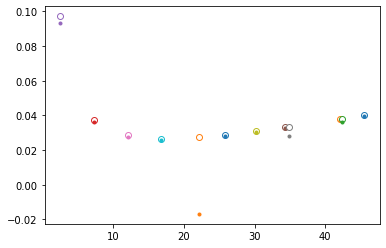

In [310]:
Qs = [(sf.find_natural_frequency(r), sf.find_mode_shape(r)) for r in range(1, 26)]
for xii, wi, phi in zip(xi, w, Phi.T):
    macs = [strid.utils.find_modal_assurance_criterion(phi, qr) for wr, qr in Qs]
    i = np.argmax(macs)
    if macs[i] < .75:
        continue
    wr, qr = Qs[i]
    err_w = (wi-wr)/wr
    mac = macs[i]
    print(f"{wi:>6.1f} | {wr:>5.1f} | {err_w:>8.1%} | {mac:>5.1%} | {i}")
    lines = plt.plot(wi, xi_true(wi), 'o', mfc="w", ms=6)
    plt.plot(wi, xii, '.', color=lines[0].get_mec())

#plt.plot(phi, label='$\\phi$')
#plt.plot(qr)
#plt.plot(sf.find_mode_shape(2))
#plt.legend()
#plt.plot(macs)

In [194]:
cs = CovSSI(Y, fs)
A = cs.compute_state_matrix_BR(10, None)
lr, Q = np.linalg.eig(A)
u = fs * np.log(lr)
w = np.sort(u.imag)
w = w[w>0]
w, xi, Q = cs.find_modal_prop(20)


plt.plot(w, xi)
print([sf.find_natural_frequency(r) for r in range(1, 11)])
print(w)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [45]:
np.log(1+1j)

(0.34657359027997264+0.7853981633974483j)

In [49]:
np.log(1+0j)

0j

In [47]:
np.log(1)

0.0